In [1]:
import pandas as pd
import numpy as np
from ebmdatalab import bq, maps, charts
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Get data from OpenPrescribing GBG measure equivalent view

In [2]:
sql = """
SELECT
  date(month) as month,
  pct,
  practice,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN items ELSE 0 END) AS items,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN possible_savings ELSE 0 END) AS possible_savings,
  SUM(net_cost) AS net_cost
FROM
  ebmdatalab.alex.vw__ghost_generic_measure_paper_2019_07
INNER JOIN
  ebmdatalab.hscic.practices
ON
  practice = code
  AND setting = 4
GROUP BY
  month,
  pct,
  practice
"""
ghost_df = bq.cached_read(sql, csv_path='ghost_generics.zip',use_cache=True)

In [3]:
ghost_df.head()

,month,pct,practice,items,possible_savings,net_cost
0,2014-03-01,03R,B87040,999,421.8923,47369.15
1,2014-03-01,09W,G82670,0,0.0000,8828.48
2,2014-03-01,15E,M85047,15,-15.2687,41033.20
3,2014-03-01,03N,C88090,0,0.0000,38107.70
4,2014-03-01,04G,K83020,0,0.0000,12864.04


In [4]:
ghost_df.month.max()

'2019-05-01'

## Practice Level Data

In [5]:
practice = ghost_df.copy()
practice['calc_val'] = (practice['possible_savings']/practice['net_cost'])*100
practice['month'] = pd.to_datetime(practice['month'])
practice = practice.sort_values(['practice','month'])
practice = practice.loc[practice['month']>='2013-05-01']
practice = practice.replace([np.inf, -np.inf], np.nan)
practice.head()

,month,pct,practice,items,possible_savings,net_cost,calc_val
672290,2013-05-01,00K,A81001,3,3.2850,32027.35,0.010257
782966,2013-06-01,00K,A81001,3,-2.1272,27785.40,-0.007656
48911,2013-07-01,00K,A81001,0,0.0000,30353.65,0.000000
154392,2013-08-01,00K,A81001,3,3.3522,30750.13,0.010901
257332,2013-09-01,00K,A81001,1,32.1800,29544.21,0.108922


In [6]:
## here we describe ranges for Decmebr 2018 - month of surfacing  the issue
df_practice_dec18 = practice.copy().loc[(practice["month"]== "2018-12-01")]
df_practice_dec18.describe()

,items,possible_savings,net_cost,calc_val
count,7077.000000,7077.000000,7077.000000,7077.000000
mean,394.732514,122.783604,50046.002319,0.246532
std,1199.923980,336.835655,35006.650667,0.676624
min,0.000000,-959.015100,0.760000,-4.146775
25%,0.000000,0.000000,25358.560000,0.000000
50%,10.000000,0.019800,43405.250000,0.000037
75%,262.000000,112.358600,66736.980000,0.254585
max,34129.000000,10177.537400,411446.550000,20.338298


In [7]:
df_practice_dec18.possible_savings.quantile(0.6)

9.661380000000019

In [8]:
df_practice_dec18.calc_val.quantile(0.99)

2.7700344547244993

## Get Data on EHRs

In [9]:
epr = pd.read_csv('GPSoC/complete.csv')
epr = epr.rename(index=str, columns={"Principal Supplier": "Principal_Supplier",
                                     "Principal System": "Principal_System"})
epr['Date'] = pd.to_datetime(epr['Date'])
epr.loc[epr['Principal_Supplier']=='TPP','Principal_Supplier'] = 'SystmOne'
epr.loc[epr['Principal_Supplier']=='INPS','Principal_Supplier'] = 'Vision'
epr = epr.drop('Unnamed: 0', axis=1)
epr.head(5)

,Date,ODS,Principal_Supplier,Principal_System
0,2016-04-01,A81622,SystmOne,SystmOne (GPSoC)
1,2016-04-01,A82018,EMIS,EMIS Web
2,2016-04-01,A82041,EMIS,EMIS Web
3,2016-04-01,A86026,SystmOne,SystmOne (GPSoC)
4,2016-04-01,B81120,SystmOne,SystmOne (GPSoC)


In [10]:
numbers = practice[['month','practice', 'possible_savings','net_cost']]
first = epr.loc[epr['Date']=='2016-03-01',['ODS','Principal_Supplier']]
last = epr.loc[epr['Date']=='2018-12-01',['ODS','Principal_Supplier']]
by_epr = numbers.merge(epr, how='left', left_on=['practice','month'], right_on=['ODS','Date'])
by_epr = by_epr.merge(first,
                      how='left',
                      left_on='practice',
                      right_on='ODS',
                      suffixes=('','_first')
                     )
'''by_epr = by_epr.merge(last,
                      how='left',
                      left_on='practice',
                      right_on='ODS',
                      suffixes=('','_last')
                     )'''
by_epr.loc[by_epr['month']<'2016-03-01','Principal_Supplier'] = by_epr.loc[by_epr['month']<'2016-03-01','Principal_Supplier_first']
#by_epr.loc[by_epr['month']>'2018-12-01','Principal_Supplier'] = by_epr.loc[by_epr['month']>'2018-12-01','Principal_Supplier_last']
by_epr = by_epr.drop(columns=['Date',
                              'ODS',
                              'Principal_System',
                              'ODS_first',
                              'Principal_Supplier_first'])#,
                              #'ODS_last',
                              #'Principal_Supplier_last'])
by_epr['Principal_Supplier'] = by_epr['Principal_Supplier'].str.strip()
by_epr2 = by_epr.groupby(['month','Principal_Supplier']).sum()
by_epr2 = by_epr2.unstack()
by_epr2.head(5)

possible_savings                                    \
Principal_Supplier             EMIS  Microtest    SystmOne     Vision   
month                                                                   
2013-05-01               10449.6221  1784.2892  73724.9958  5581.4633   
2013-06-01               -2513.7045  1859.7147  63401.6698  2988.0021   
2013-07-01              -10007.7752   785.8605  61031.5563  2142.5114   
2013-08-01               -3879.6426   534.0611  57043.1956   979.6838   
2013-09-01                9182.9108   736.4783  60155.0313   885.8858   

                        net_cost                                         
Principal_Supplier          EMIS   Microtest      SystmOne       Vision  
month                                                                    
2013-05-01          2.031396e+08  5168099.20  1.350999e+08  26842613.04  
2013-06-01          1.883684e+08  4787855.42  1.247724e+08  25003873.80  
2013-07-01          2.033367e+08  5202434.11  1.347439e+08  26798668.44  
2013-08-01          1.955451e+08  5090730.44  1.302076e+08  25851248.36  
2013-09-01          1.906725e+08  4849766.69  1.258965e+08  25368602.80

In [11]:
by_epr.sort_values('month')

,month,practice,possible_savings,net_cost,Principal_Supplier
0,2013-05-01,A81001,3.2850,32027.35,SystmOne
111414,2013-05-01,C86009,-17.4984,79817.54,SystmOne
111415,2013-05-01,C86009,-17.4984,79817.54,SystmOne
476782,2013-05-01,N83612,2.1900,26306.07,EMIS
111562,2013-05-01,C86011,21.2513,120958.89,SystmOne
476725,2013-05-01,N83611,0.0000,25349.06,EMIS
111635,2013-05-01,C86012,-3.4875,42928.27,EMIS
476652,2013-05-01,N83610,0.0000,20567.14,EMIS
111708,2013-05-01,C86013,-359.0404,95961.07,SystmOne
476579,2013-05-01,N83609,0.0000,25322.50,EMIS


In [12]:
ehr_by_ccg = pd.merge(by_epr, practice[['practice', 'month' ,'calc_val']].drop_duplicates(), left_on=['practice', 'month'], right_on= ['practice', 'month'], how='left')
ehr_by_ccg.head(5)

,month,practice,possible_savings,net_cost,Principal_Supplier,calc_val
0,2013-05-01,A81001,3.2850,32027.35,SystmOne,0.010257
1,2013-06-01,A81001,-2.1272,27785.40,SystmOne,-0.007656
2,2013-07-01,A81001,0.0000,30353.65,SystmOne,0.000000
3,2013-08-01,A81001,3.3522,30750.13,SystmOne,0.010901
4,2013-09-01,A81001,32.1800,29544.21,SystmOne,0.108922


In [13]:
df_sysone_prac = ehr_by_ccg.loc[ehr_by_ccg['Principal_Supplier']=='SystmOne']
df_sysone_prac.head(5)

,month,practice,possible_savings,net_cost,Principal_Supplier,calc_val
0,2013-05-01,A81001,3.2850,32027.35,SystmOne,0.010257
1,2013-06-01,A81001,-2.1272,27785.40,SystmOne,-0.007656
2,2013-07-01,A81001,0.0000,30353.65,SystmOne,0.000000
3,2013-08-01,A81001,3.3522,30750.13,SystmOne,0.010901
4,2013-09-01,A81001,32.1800,29544.21,SystmOne,0.108922


In [14]:
##here we show ranges for December 2018
df_sysymone_dec18 = df_sysone_prac.copy().loc[(df_sysone_prac["month"]== "2018-12-01")]
df_sysymone_dec18.describe()

,possible_savings,net_cost,calc_val
count,2610.000000,2610.000000,2610.000000
mean,324.035261,53931.420421,0.641623
std,483.113571,38481.093413,0.942523
min,-959.015100,1.960000,-1.618454
25%,71.884425,27485.050000,0.181659
50%,189.835700,46772.660000,0.419179
75%,405.024850,71404.692500,0.794548
max,10177.537400,411446.550000,20.338298


In [15]:
df_sysymone_dec18.calc_val.quantile(0.99)

4.054294904513536

# CCG level data

In [16]:
ccg = ghost_df.copy()
ccg['month'] = pd.to_datetime(ccg['month'])
ccg = ccg.groupby(['pct','month'],as_index=False).sum()
ccg['calc_val'] = (ccg['possible_savings']/ccg['net_cost'])*100
ccg = ccg.sort_values(['pct','month'])
ccg = ccg.loc[ccg['month']>='2013-05-01']
ccg = ccg.replace([np.inf, -np.inf], np.nan)
#ccg = ccg.dropna(axis=0)

ccg.head()

,pct,month,items,possible_savings,net_cost,calc_val
33,00C,2013-05-01,1599,182.1012,837702.68,0.021738
34,00C,2013-06-01,937,262.1197,765487.02,0.034242
35,00C,2013-07-01,723,597.9922,838177.76,0.071344
36,00C,2013-08-01,775,107.6665,814721.45,0.013215
37,00C,2013-09-01,815,229.1338,771460.68,0.029701


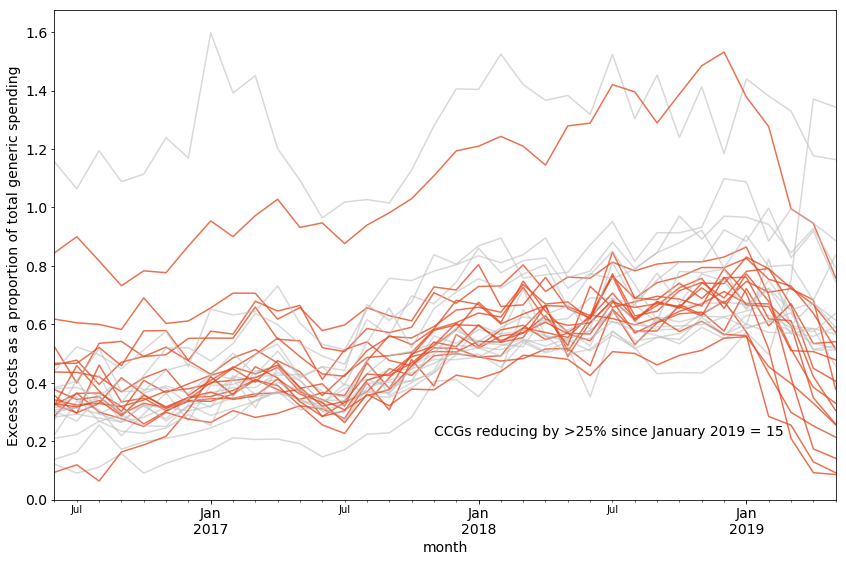

In [17]:
##this is finding those CCGs who have changed
top_n = ccg.loc[ccg['month']=='2019-01-01']
top_n = top_n.sort_values('calc_val',ascending=False)
top_n = top_n.head(30)
before = top_n[['pct','calc_val']].set_index('pct')
top_n = top_n[['pct']]
top_n = top_n.set_index('pct')

most_recent = ccg.loc[ccg['month']==ccg['month'].max(),['pct','calc_val']]
most_recent = most_recent.merge(top_n,how='right',left_on='pct',right_index=True)
most_recent = most_recent.set_index('pct')

'''
change = before - most_recent
change = change - change.min()
change = change / (change.max()-change.min())
change = change['calc_val']
#change = 1-change
'''
change = before - most_recent
change = change / before
change = change['calc_val']

ccg_unstacked = ccg.loc[ccg['month']>='2016-06-01']
ccg_unstacked = ccg_unstacked.merge(top_n,how='right',on='pct')
ccg_unstacked = ccg_unstacked.groupby(['month','pct']).sum()
ccg_unstacked = ccg_unstacked.unstack()

#from matplotlib import cm
#colors = [cm.coolwarm(x) for x in change]
def color_pick(x):
    if x < 0.25:
        return (0.75,0.75,0.75,0.6)
    else:
        return (0.9,0.3,0.15,0.8)
colors = [color_pick(x) for x in change]

f = plt.figure(figsize=(14, 9))
layout = gridspec.GridSpec(1, 1, figure=f)
ax = plt.subplot(layout[0])
ccg_unstacked['calc_val'].plot(ax=ax,color=colors)
#ax.axvline('2018-12-01',color='r',linestyle=':', label='DataLab Discover and Announce GBG')
#ax.axvline('2019-02-01',color='k',linestyle='--', label='SystmOne deploy fix') ## it was last week of Feb, I think a case for setting as march
ax.text('2017-11-01',
        0.22,
        'CCGs reducing by >25% since January 2019 = {}'.format((change >= 0.25).sum()),
        fontsize=14)
ax.set_ylabel('Excess costs as a proportion of total generic spending')
ax.set_ylim(0,)
ax.legend().remove()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
plt.savefig(r'gbg_images\CCGs_that_have_changed.png')
plt.show()

In [18]:
## ensuring the format is consistent for pounds and pence
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [19]:
## here we calculate ranges for december 2018
ccg_dec18 = ccg.copy().loc[(ccg["month"]== "2018-12-01")]
ccg_dec18.describe()

,items,possible_savings,net_cost,calc_val
count,192.00,192.00,192.00,192.00
mean,14549.59,4525.73,1844664.37,0.24
std,20758.34,6266.70,1150108.02,0.29
min,71.00,-197.52,50003.30,-0.02
25%,554.75,72.26,1165876.22,0.01
50%,4395.50,1451.99,1544733.47,0.12
75%,21802.00,7065.96,2108321.47,0.43
max,142769.00,34664.49,8129220.73,1.53


# Most recent month map


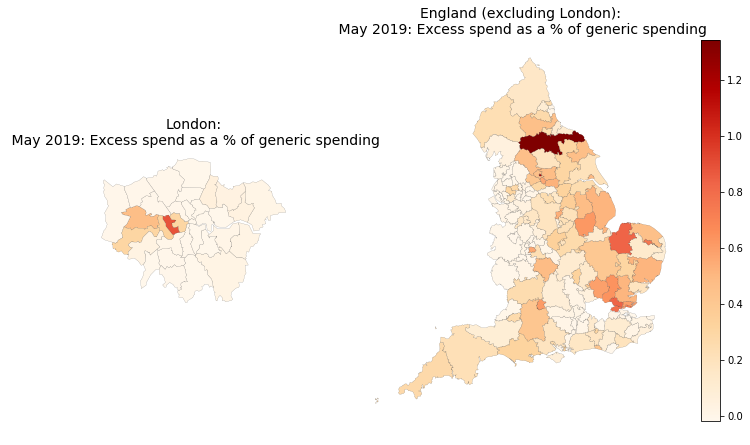

In [20]:
plt.figure(figsize=(12, 7))
ccg_for_map = ccg.loc[ccg['pct']!='112']
last_month = ccg_for_map.loc[ccg['month']==ccg['month'].max()]
maps.ccg_map(last_month, title=" May 2019: Excess spend as a % of generic spending",
             column='calc_val', 
             separate_london=True)
plt.savefig(r'gbg_images\gbg_fig3_ccgmap.png')
plt.show()

# Declie plots

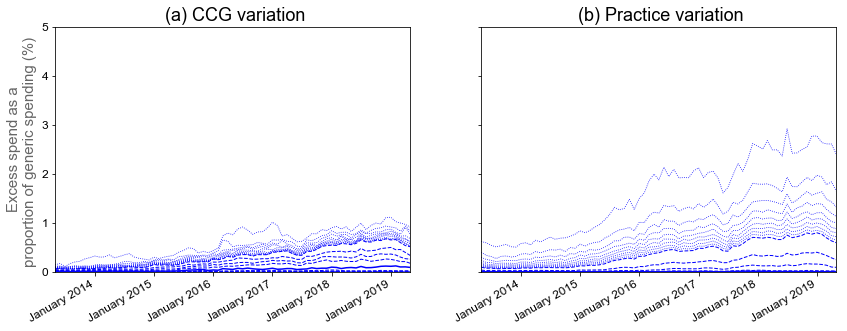

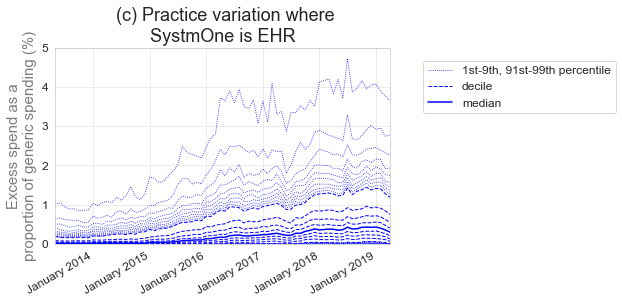

In [21]:
f = plt.figure(figsize=(14, 5))
#f.suptitle('Sharing Y axis')
f.autofmt_xdate()
layout = gridspec.GridSpec(1, 2, figure=f)
left_plot = plt.subplot(layout[0])
right_plot = plt.subplot(layout[1], sharey=left_plot)  # Share the Y axis 

# ...and because it's shared, suppress ticks on the second chart
plt.setp(right_plot.get_yticklabels(), visible=False)

charts.deciles_chart(
    ccg,
    period_column='month',
    column='calc_val',
    title=" (a) CCG variation",
    ylabel="Excess spend as a\nproportion of generic spending (%) ",
    show_outer_percentiles=True,
    show_legend=False,
    ax=left_plot,  
) 


charts.deciles_chart(
    practice,
    period_column='month',
    column='calc_val',
    title=" (b) Practice variation",
    ylabel="",
    show_outer_percentiles=True,
    show_legend=False,
    ax=right_plot,
) 
plt.ylim(0, 5)

charts.deciles_chart(
        df_sysone_prac,
        period_column='month',
        column='calc_val',
        title=" (c) Practice variation where\nSystmOne is EHR",
        ylabel= "Excess spend as a\nproportion of generic spending (%)",
        show_outer_percentiles=True,
        show_legend=True,
   
)
plt.ylim(0, 5)
plt.savefig('deciles.png', format='png', dpi=300,bbox_inches='tight')
plt.savefig(r'gbg_images\gbg_fig2_deciles_ccgprac.png')
plt.show()

# Total items and total excess costs

In [22]:
totals = practice.groupby('month').sum()

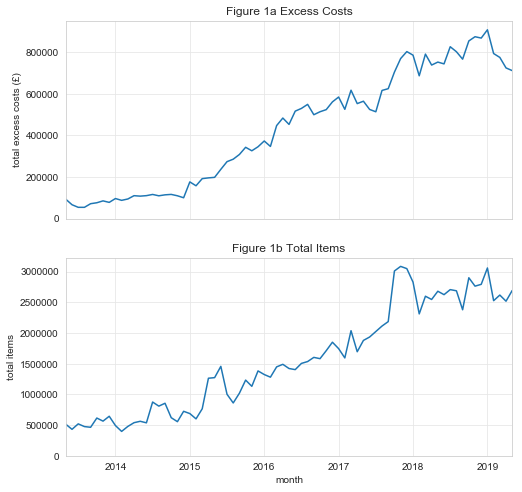

In [23]:
f = plt.figure(figsize=(8, 8))
layout = gridspec.GridSpec(2, 1, figure=f)
top_plot = plt.subplot(layout[0])
bottom_plot = plt.subplot(layout[1], sharex=top_plot)  # Share the Y axis 

ax = totals['possible_savings'].plot(ax=top_plot)
ax.set_ylabel('total excess costs (£)')
ax.set_ylim(0,)
ax.set_title('Figure 1a Excess Costs')
ax = totals['items'].plot(ax=bottom_plot)
ax.set_ylabel('total items')
ax.set_ylim(0,)
ax.set_title('Figure 1b Total Items')
plt.savefig('Fig 1.png', format='png', dpi=300,bbox_inches='tight')
plt.savefig(r'gbg_images\gbg_fig1_totalexcess_costitems.png')
plt.show()

## Annual totals
Ignore 2013 and 2019, as they're not complete years

In [24]:
totals[['items','possible_savings','net_cost']].resample('Y').sum()

,items,possible_savings,net_cost
month,,,
2013-12-31,4230471,579453.37,2921595654.74
2014-12-31,7450972,1274305.16,4397095372.51
2015-12-31,12682532,3042560.95,4653772146.18
2016-12-31,18160701,5803759.61,4538159996.75
2017-12-31,26362016,7408321.02,4547796313.47
2018-12-31,31828556,9499881.51,4249644635.03
2019-12-31,13418966,3916495.41,1769088242.45


# Stratify by EHR

Rerun GPSoC file aggregation if new months need to be added:

In [25]:
#%run -i "GPSoC/make_csv.py"

In [26]:
sql = """
        SELECT
          DATE(Date) AS Date,
          ODS,
          TRIM(Principal_Supplier) AS Principal_Supplier,
          TRIM(Principal_System) AS Principal_System
        FROM
          alex.vendors software"""
epr = bq.cached_read(sql, csv_path='software_vendor.zip')
epr['Date'] = pd.to_datetime(epr['Date'])
epr.loc[epr['Principal_Supplier']=='TPP','Principal_Supplier'] = 'SystmOne'
epr.loc[epr['Principal_Supplier']=='INPS','Principal_Supplier'] = 'Vision'
epr.head()

,Date,ODS,Principal_Supplier,Principal_System
0,2016-02-01,E82613,Unknown,Unknown
1,2016-02-01,E82630,Unknown,Unknown
2,2016-02-01,E82656,Unknown,Unknown
3,2016-02-01,E83629,Unknown,Unknown
4,2016-02-01,E83632,Unknown,Unknown


In [27]:
epr_march19 = epr.loc[epr['Date']=='2019-03-01',['ODS','Principal_Supplier', 'Date']]
epr_march19.head(5)

,ODS,Principal_Supplier,Date
48534,A81023,SystmOne,2019-03-01
48535,A84043,SystmOne,2019-03-01
48536,A86026,SystmOne,2019-03-01
48537,B84002,SystmOne,2019-03-01
48538,B84010,SystmOne,2019-03-01


In [28]:
epr_march19.groupby('Principal_Supplier').count()

,ODS,Date
Principal_Supplier,,
EMIS,4064,4064
Microtest,52,52
SystmOne,2700,2700
Vision,315,315


In [29]:
numbers = practice[['month','practice', 'possible_savings','net_cost']]
first = epr.loc[epr['Date']=='2016-03-01',['ODS','Principal_Supplier']]
last = epr.loc[epr['Date']=='2018-12-01',['ODS','Principal_Supplier']]
by_epr = numbers.merge(epr, how='left', left_on=['practice','month'], right_on=['ODS','Date'])
by_epr = by_epr.merge(first,
                      how='left',
                      left_on='practice',
                      right_on='ODS',
                      suffixes=('','_first')
                     )
'''by_epr = by_epr.merge(last,
                      how='left',
                      left_on='practice',
                      right_on='ODS',
                      suffixes=('','_last')
                     )'''
by_epr.loc[by_epr['month']<'2016-03-01','Principal_Supplier'] = by_epr.loc[by_epr['month']<'2016-03-01','Principal_Supplier_first']
#by_epr.loc[by_epr['month']>'2018-12-01','Principal_Supplier'] = by_epr.loc[by_epr['month']>'2018-12-01','Principal_Supplier_last']
by_epr = by_epr.drop(columns=['Date',
                              'ODS',
                              'Principal_System',
                              'ODS_first',
                              'Principal_Supplier_first'])#,
                              #'ODS_last',
                              #'Principal_Supplier_last'])
by_epr['Principal_Supplier'] = by_epr['Principal_Supplier'].str.strip()
by_epr2 = by_epr.groupby(['month','Principal_Supplier']).sum()
by_epr2 = by_epr2.unstack()
by_epr2.head()

possible_savings                                net_cost  \
Principal_Supplier             EMIS Microtest SystmOne  Vision         EMIS   
month                                                                         
2013-05-01                 10449.62   1784.29 73725.00 5581.46 203139630.46   
2013-06-01                 -2513.70   1859.71 63401.67 2988.00 188368361.14   
2013-07-01                -10007.78    785.86 61031.56 2142.51 203336665.79   
2013-08-01                 -3879.64    534.06 57043.20  979.68 195545056.22   
2013-09-01                  9182.91    736.48 60155.03  885.89 190672546.14   

                                                        
Principal_Supplier  Microtest     SystmOne      Vision  
month                                                   
2013-05-01         5168099.20 135099850.24 26842613.04  
2013-06-01         4787855.42 124772437.12 25003873.80  
2013-07-01         5202434.11 134743882.07 26798668.44  
2013-08-01         5090730.44 130207636.50 25851248.36  
2013-09-01         4849766.69 125896498.94 25368602.80

In [30]:
by_epr.head(5)

,month,practice,possible_savings,net_cost,Principal_Supplier
0,2013-05-01,A81001,3.29,32027.35,SystmOne
1,2013-06-01,A81001,-2.13,27785.40,SystmOne
2,2013-07-01,A81001,0.00,30353.65,SystmOne
3,2013-08-01,A81001,3.35,30750.13,SystmOne
4,2013-09-01,A81001,32.18,29544.21,SystmOne


### EHR Usage by CCG - SystmOne Deciles

In [31]:
ehr_by_ccg = pd.merge(by_epr, practice[['practice', 'month' ,'calc_val']].drop_duplicates(), left_on=['practice', 'month'], right_on= ['practice', 'month'], how='left')
ehr_by_ccg.head(5)

,month,practice,possible_savings,net_cost,Principal_Supplier,calc_val
0,2013-05-01,A81001,3.29,32027.35,SystmOne,0.01
1,2013-06-01,A81001,-2.13,27785.40,SystmOne,-0.01
2,2013-07-01,A81001,0.00,30353.65,SystmOne,0.00
3,2013-08-01,A81001,3.35,30750.13,SystmOne,0.01
4,2013-09-01,A81001,32.18,29544.21,SystmOne,0.11


In [32]:
df_sysone_prac = ehr_by_ccg.loc[ehr_by_ccg['Principal_Supplier']=='SystmOne']
df_sysone_prac.head(5)

,month,practice,possible_savings,net_cost,Principal_Supplier,calc_val
0,2013-05-01,A81001,3.29,32027.35,SystmOne,0.01
1,2013-06-01,A81001,-2.13,27785.40,SystmOne,-0.01
2,2013-07-01,A81001,0.00,30353.65,SystmOne,0.00
3,2013-08-01,A81001,3.35,30750.13,SystmOne,0.01
4,2013-09-01,A81001,32.18,29544.21,SystmOne,0.11


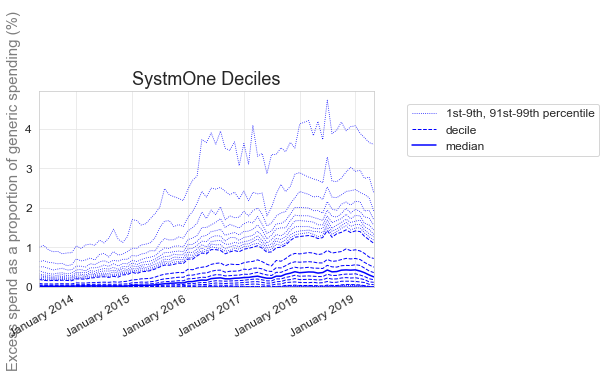

In [33]:
charts.deciles_chart(
        df_sysone_prac,
        period_column='month',
        column='calc_val',
        title="SystmOne Deciles",
        ylabel="Excess spend as a proportion of generic spending (%) ",
        show_outer_percentiles=True,
        show_legend=True
)
plt.savefig('deciles.png', format='png', dpi=300,bbox_inches='tight')
plt.savefig(r'gbg_images\ehrshare_latestmonth.png')
plt.show()

## Total possible savings

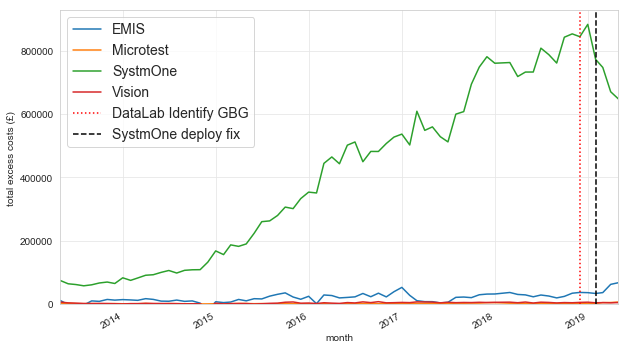

In [34]:
f = plt.figure(figsize=(10, 6))
layout = gridspec.GridSpec(1, 1, figure=f)
ax = plt.subplot(layout[0])
ax = by_epr2['possible_savings'].plot(ax=ax)
ax.axvline('2018-12-01',color='r',linestyle=':', label='DataLab Identify GBG')
ax.axvline('2019-02-01',color='k',linestyle='--', label='SystmOne deploy fix')
ax.legend()
plt.legend(fontsize=14)
ax.set_ylabel('total excess costs (£) ')
ax.set_ylim(0,)
plt.savefig('savings_by_EHR.png', format='png', dpi=300,bbox_inches='tight')
plt.savefig(r'gbg_images\gbg_fig4_totalcosts_ehr.png')
plt.show()

## Total savings/total generic prescribing costs

In [35]:
measure = by_epr2['possible_savings'] / by_epr2['net_cost']
measure.head()

Principal_Supplier,EMIS,Microtest,SystmOne,Vision
month,,,,
2013-05-01,0.00,0.00,0.00,0.00
2013-06-01,-0.00,0.00,0.00,0.00
2013-07-01,-0.00,0.00,0.00,0.00
2013-08-01,-0.00,0.00,0.00,0.00
2013-09-01,0.00,0.00,0.00,0.00


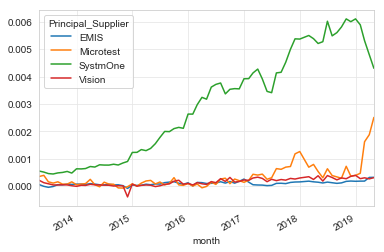

In [36]:
measure.plot()
plt.savefig(r'gbg_images\gbg_figx_measures.png')

# SystmOne Only

In [37]:
systmone = by_epr2['possible_savings']['SystmOne']
systmone.head()

month
2013-05-01   73725.00
2013-06-01   63401.67
2013-07-01   61031.56
2013-08-01   57043.20
2013-09-01   60155.03
Name: SystmOne, dtype: float64

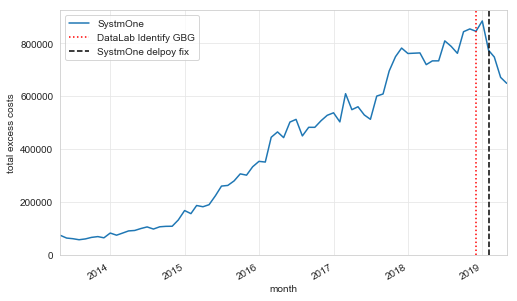

In [38]:
f = plt.figure(figsize=(8, 5))
layout = gridspec.GridSpec(1, 1, figure=f)
ax = plt.subplot(layout[0])
ax = systmone.plot(ax=ax)
ax.axvline('2018-12-01',color='r',linestyle=':', label='DataLab Identify GBG')
ax.axvline('2019-02-01',color='k',linestyle='--', label='SystmOne delpoy fix') ## it was last week of Feb, I think a case for setting as march
ax.set_ylabel('total excess costs')
ax.set_ylim(0,)
ax.legend()
plt.savefig('systmone_only.png', format='png', dpi=300,bbox_inches='tight')
plt.savefig(r'gbg_images\gbg_fig5_systmone.png')
plt.show()

# Top ten GBG chemicals in 2018

In [39]:
sql = """
WITH
  chem_map AS(
  SELECT
    DISTINCT chemical_code,
    chemical
  FROM
    ebmdatalab.hscic.bnf)
SELECT
  SUBSTR(bnf_code,1,9) AS chem_code,
  chemical,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN items ELSE 0 END) AS items,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN possible_savings ELSE 0 END) AS excess_spend
FROM
  ebmdatalab.alex.vw__ghost_generic_measure_paper_2019_07
INNER JOIN
  ebmdatalab.hscic.practices
ON
  practice = code
  AND setting = 4
LEFT JOIN
  chem_map
ON
  SUBSTR(bnf_code,1,9) = chemical_code
WHERE
  month >= '2018-01-01'
  AND month <= '2018-12-01'
GROUP BY
  chem_code,
  chemical
ORDER BY
  excess_spend DESC
"""
by_chem = bq.cached_read(sql, csv_path='by_chem.zip')

In [40]:
by_chem.head(10)

,chem_code,chemical,items,excess_spend
0,0212000B0,Atorvastatin,5559934,1694635.63
1,0408010AE,Pregabalin,159404,665385.08
2,0411000G0,Memantine Hydrochloride,100196,513419.64
3,0303020G0,Montelukast,241626,298153.93
4,0402010AD,Aripiprazole,18605,269940.04
5,0205052N0,Losartan Potassium,786568,269048.04
6,0402010AB,Quetiapine,89215,235940.00
7,0206020A0,Amlodipine,2719024,219620.47
8,0403010X0,Trazodone Hydrochloride,26298,212322.99
9,0603020T0,Prednisolone,103825,180958.73


In [41]:
by_chem.sort_values('items',ascending=False).head(10)

,chem_code,chemical,items,excess_spend
0,0212000B0,Atorvastatin,5559934,1694635.63
16,0103050P0,Omeprazole,3664839,133583.12
13,0103050L0,Lansoprazole,2827832,153589.42
7,0206020A0,Amlodipine,2719024,219620.47
46,0601022B0,Metformin Hydrochloride,1283610,39942.21
24,0204000H0,Bisoprolol Fumarate,1186282,102676.65
12,0209000C0,Clopidogrel,1130301,167058.98
32,0212000Y0,Simvastatin,1002033,60841.19
59,040702040,Tramadol Hydrochloride,985678,30995.62
47,0602010V0,Levothyroxine Sodium,889756,39727.58


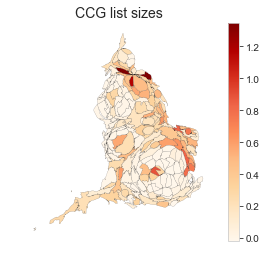

In [42]:
###suggested by Helen to be reviewed before submission
plt = maps.ccg_map(
    last_month, 
    title="CCG list sizes", 
    column='calc_val', 
    cartogram=True, 
    separate_london=False)
plt.show()